# 🏎️ Model 1: Random Forest - Multi-Target Prediction

**Goal:** Predict multiple F1 race outcomes using Random Forest

**Targets:**
- 🏆 **Classification**: win, podium, points_finish, top5 (binary 0/1)
- 📊 **Regression**: position (1-20)

**Process:**
1. Train baseline models (Classifier + Regressor)
2. Hyperparameter optimization for both
3. Compare baseline vs optimized
4. Evaluate and visualize all targets
5. Save best models

## Step 1 : Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    r2_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    make_scorer
)

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 10

## Step 2 : Loading Data 

In [3]:
print("Loading processed data")

train_df = pd.read_parquet('../data/processed/train_data_v2.parquet')
test_df = pd.read_parquet('../data/processed/test_data_v2.parquet')

train_weights = np.load('../data/processed/train_weights.npy')
test_weights = np.load('../data/processed/test_weights.npy')

with open('../data/processed/metadata_v2.json', 'r') as f:
    metadata = json.load(f)

print(f"\n Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")
print(f"   Target columns: {metadata['target_columns']}")    

Loading processed data

 Data loaded successfully!
   Training samples: 460 (2024 season)
   Test samples: 385 (2025 season)
   Features: 72
   Target columns: ['win', 'podium', 'points_finish', 'top5', 'position']


## Step 3 : Preparing Features and Targets

In [4]:
feature_cols = metadata['feature_columns']

classification_targets = ['win','podium','points_finish','top5']
regression_target = 'position'
all_targets = classification_targets + [regression_target]

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_class = train_df[classification_targets]
y_test_class = test_df[classification_targets]

print(f"\n Data prepared for training:")
print(f"   Features shape: {X_train.shape}")
print(f"   Classification targets: {classification_targets}")

print(f"\n Target Distribution (Training):")
for target in classification_targets:
    pos_rate = train_df[target].mean() * 100
    print(f"   {target}: {pos_rate:.1f}% positive")


 Data prepared for training:
   Features shape: (460, 72)
   Classification targets: ['win', 'podium', 'points_finish', 'top5']

 Target Distribution (Training):
   win: 5.2% positive
   podium: 15.7% positive
   points_finish: 50.9% positive
   top5: 26.1% positive


## Step 4 : Evaluation Functions

In [17]:
def calculate_classification_metrics(y_true,y_pred,y_prob=None,weights=None,target_name="Target"):

    acc = accuracy_score(y_true, y_pred, sample_weight = weights)
    prec = precision_score(y_true, y_pred, sample_weight = weights)
    rec = recall_score(y_true,y_pred,sample_weight = weights)
    f1 = f1_score(y_true,y_pred,sample_weight = weights)

    auc = roc_auc_score(y_true, y_prob,sample_weight = weights) if y_prob is not None else None

    return {
        'Accuracy' : acc,
        'Precision' : prec,
        'Recall' : rec,
        'F1' : f1,
        'AUC' : auc
    }


def print_classification_metrics(train_metrics, test_metrics, title="Classification Metrics"):
    
    print("\n" + "=" * 80)
    print(f" {title}")
    print("=" * 80)
    
    
    print(f"{'Metric':<15} {'Train':>15} {'Test':>15}")
    print("-" * 80)
    

    print(f"{'Accuracy':<15} {train_metrics['Accuracy']:.3f} ({train_metrics['Accuracy']*100:5.1f}%)   {test_metrics['Accuracy']:.3f} ({test_metrics['Accuracy']*100:5.1f}%)")
    print(f"{'Precision':<15} {train_metrics['Precision']:.3f}{'':>12}{test_metrics['Precision']:.3f}")
    print(f"{'Recall':<15} {train_metrics['Recall']:.3f}{'':>12}{test_metrics['Recall']:.3f}")
    print(f"{'F1 Score':<15} {train_metrics['F1']:.3f}{'':>12}{test_metrics['F1']:.3f}")
    
    if train_metrics.get('AUC') is not None and test_metrics.get('AUC') is not None:
        print(f"{'ROC AUC':<15} {train_metrics['AUC']:.3f}{'':>12}{test_metrics['AUC']:.3f}")
    
    print("=" * 80)


# PART A : CLASSIFICATION MODELS (win,podium,top5,points_finish)

## Step 5 : Baseline classification models

In [18]:
baseline_class_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': 42,
    'n_jobs': -1
}

print("\n Baseline Classification Parameters:")
for param, value in baseline_class_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"   {param}: {value}")

baseline_class_models = {}
baseline_class_results = {}

for target in classification_targets:
    print(f"\n  Training baseline classifier for '{target}'...")
    
    model = RandomForestClassifier(**baseline_class_params)
    model.fit(X_train, y_train_class[target], sample_weight=train_weights)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]
    
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights, target
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights, target
    )
    
    baseline_class_models[target] = model
    baseline_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'train_prob': train_prob,
        'test_prob': test_prob
    }

    print_classification_metrics(train_metrics,test_metrics)
    print("="*70)

print("\n✅ All baseline classification models trained!")


 Baseline Classification Parameters:
   n_estimators: 100
   max_depth: 15
   min_samples_split: 10
   min_samples_leaf: 4
   max_features: sqrt
   class_weight: balanced

  Training baseline classifier for 'win'...

 Classification Metrics
Metric                    Train            Test
--------------------------------------------------------------------------------
Accuracy        0.974 ( 97.4%)   0.945 ( 94.5%)
Precision       0.667            0.477
Recall          1.000            0.579
F1 Score        0.800            0.523
ROC AUC         0.998            0.958

  Training baseline classifier for 'podium'...

 Classification Metrics
Metric                    Train            Test
--------------------------------------------------------------------------------
Accuracy        0.914 ( 91.4%)   0.909 ( 90.9%)
Precision       0.657            0.654
Recall          0.961            0.888
F1 Score        0.781            0.753
ROC AUC         0.984            0.952

  Training baselin


### **Baseline Classification Results**

- This cell trains the four baseline classifiers, which clearly demonstrate **overfitting**.

- The models performed perfectly on the 2024 training data (e.g., the `win` model achieved 100% recall and an 80% F1), but their performance dropped significantly on the unseen 2025 test set (the `win` model's F1 fell to 52.3%).

- This large gap between training and test scores shows the models "memorized" the 2024 season instead of learning general patterns.

- The next hyperparameter tuning step is essential to reduce this overfitting and improve real-world performance.

## Step 6 : Optimize Classification models

In [39]:
class_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.7, 0.8, 0.9, None]
}

print("\n Classification Search Space:")
print(f"   Testing 30 random combinations per target")
print(f"   Using 3-fold TIME SERIES CV with F1 scoring") 

optimized_class_models = {}
optimized_class_results = {}
cv_results_class = {}

tscv = TimeSeriesSplit(n_splits = 3)

for target in  classification_targets:

    print(f"\nOptimizing '{target} classifier")

    f1_scorer = make_scorer(f1_score)

    random_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=class_param_grid,
        n_iter=30,
        scoring=f1_scorer,
        cv=tscv,  
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    random_search.fit(X_train,y_train_class[target],sample_weight = train_weights)
    
    best_model = random_search.best_estimator_

    train_pred = best_model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]

    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights, target
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights, target
    )

    optimized_class_models[target] = best_model
    optimized_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'best_params': random_search.best_params_
    }

    cv_results_class[target] = pd.DataFrame(random_search.cv_results_)

    print(f"    Best F1: {random_search.best_score_:.3f}")
    print(f"     {target}: Test Accuracy = {test_metrics['Accuracy']*100:.1f}%, "
          f"F1 = {test_metrics['F1']*100:.1f}%, AUC = {test_metrics['AUC']*100:.1f}%, "
          f"Precision = {test_metrics['Precision']*100:.1f}%, Recall = {test_metrics['Recall']*100:.1f}%")

print("\n All classification models optimized!")


 Classification Search Space:
   Testing 30 random combinations per target
   Using 3-fold TIME SERIES CV with F1 scoring

Optimizing 'win classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best F1: 0.362
     win: Test Accuracy = 77.7%, F1 = 31.9%, AUC = 93.6%, Precision = 19.0%, Recall = 100.0%

Optimizing 'podium classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best F1: 0.667
     podium: Test Accuracy = 85.8%, F1 = 67.2%, AUC = 94.4%, Precision = 52.7%, Recall = 92.6%

Optimizing 'points_finish classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best F1: 0.843
     points_finish: Test Accuracy = 71.1%, F1 = 63.8%, AUC = 80.6%, Precision = 92.4%, Recall = 48.7%

Optimizing 'top5 classifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits
    Best F1: 0.794
     top5: Test Accuracy = 87.2%, F1 = 76.2%, AUC = 90.7%, Precision = 74.2%, Recall = 78.2%

 All classification models optimized!


## Step 7 : Compare Classification Models

In [40]:
print("\n" + "="*80)
print("📊 CLASSIFICATION MODELS COMPARISON")
print("="*80)

comparison_class_data = []

for target in classification_targets:
    baseline = baseline_class_results[target]['test_metrics']
    optimized = optimized_class_results[target]['test_metrics']
    
    improvement = {
        'Target': target,
        'Baseline_Acc': baseline['Accuracy'],
        'Optimized_Acc': optimized['Accuracy'],
        'Baseline_F1': baseline['F1'],
        'Optimized_F1': optimized['F1'],
        'Baseline_AUC': baseline['AUC'],
        'Optimized_AUC': optimized['AUC'],
        'F1_Improvement': ((optimized['F1'] - baseline['F1']) / baseline['F1'] * 100) if baseline['F1'] > 0 else 0
    }
    comparison_class_data.append(improvement)

comparison_class_df = pd.DataFrame(comparison_class_data)

print("\n")
display(comparison_class_df)

print("\n💡 IMPROVEMENTS:")
for _, row in comparison_class_df.iterrows():
    if row['F1_Improvement'] > 0:
        print(f"   ✅ {row['Target']}: F1 improved by {row['F1_Improvement']:.1f}%")
    else:
        print(f"   ⚠️  {row['Target']}: Baseline F1 was better")


📊 CLASSIFICATION MODELS COMPARISON




,Target,Baseline_Acc,Optimized_Acc,Baseline_F1,Optimized_F1,Baseline_AUC,Optimized_AUC,F1_Improvement
0,win,0.944922,0.777223,0.523199,0.318970,0.958382,0.936231,-39.034686
1,podium,0.908995,0.858320,0.753445,0.671625,0.952355,0.943686,-10.859444
2,points_finish,0.783880,0.711413,0.792623,0.637750,0.846509,0.806066,-19.539386
3,top5,0.872362,0.872362,0.761781,0.761781,0.907088,0.907088,0.000000



💡 IMPROVEMENTS:
   ⚠️  win: Baseline F1 was better
   ⚠️  podium: Baseline F1 was better
   ⚠️  points_finish: Baseline F1 was better
   ⚠️  top5: Baseline F1 was better


## Step 8 : Vizualise Classification Results

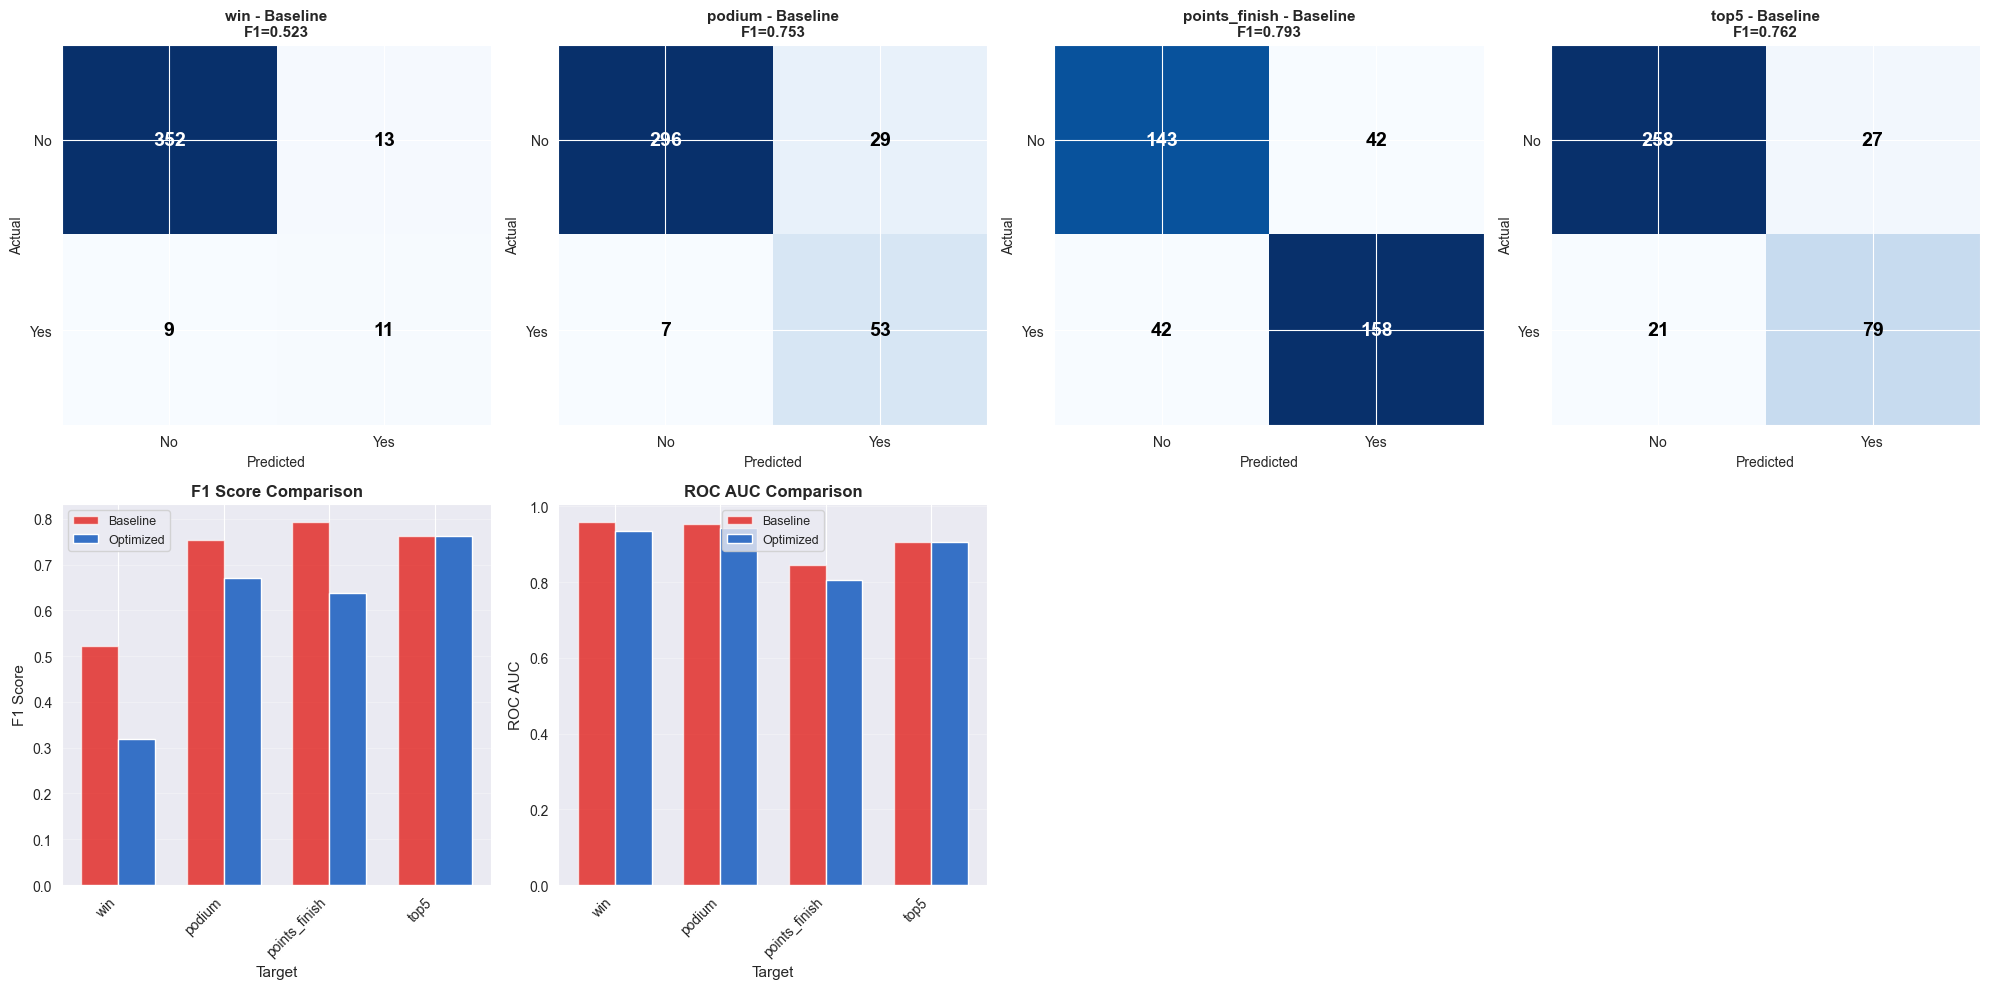

✅ Classification visualizations complete!


In [41]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, target in enumerate(classification_targets):
    # Get best model results
    if optimized_class_results[target]['test_metrics']['F1'] > baseline_class_results[target]['test_metrics']['F1']:
        results = optimized_class_results[target]
        model_type = "Optimized"
        color = '#3671C6'
    else:
        results = baseline_class_results[target]
        model_type = "Baseline"
        color = '#E10600'
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_class[target], results['test_pred'])
    
    axes[idx].imshow(cm, cmap='Blues', aspect='auto')
    axes[idx].set_title(f'{target} - {model_type}\nF1={results["test_metrics"]["F1"]:.3f}', 
                       fontweight='bold', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels(['No', 'Yes'])
    axes[idx].set_yticklabels(['No', 'Yes'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            axes[idx].text(j, i, str(cm[i, j]), 
                          ha='center', va='center', 
                          color='white' if cm[i, j] > cm.max()/2 else 'black',
                          fontsize=14, fontweight='bold')

# Metrics comparison
ax = axes[4]
metrics_data = []
for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics']['F1']
    metrics_data.append({'target': target, 'Baseline': baseline_f1, 'Optimized': optimized_f1})

metrics_df = pd.DataFrame(metrics_data)
x = np.arange(len(classification_targets))
width = 0.35

ax.bar(x - width/2, metrics_df['Baseline'], width, label='Baseline', color='#E10600', alpha=0.7)
ax.bar(x + width/2, metrics_df['Optimized'], width, label='Optimized', color='#3671C6')
ax.set_xlabel('Target', fontsize=11)
ax.set_ylabel('F1 Score', fontsize=11)
ax.set_title('F1 Score Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classification_targets, rotation=45, ha='right')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# AUC comparison
ax = axes[5]
auc_data = []
for target in classification_targets:
    baseline_auc = baseline_class_results[target]['test_metrics']['AUC']
    optimized_auc = optimized_class_results[target]['test_metrics']['AUC']
    auc_data.append({'target': target, 'Baseline': baseline_auc, 'Optimized': optimized_auc})

auc_df = pd.DataFrame(auc_data)
ax.bar(x - width/2, auc_df['Baseline'], width, label='Baseline', color='#E10600', alpha=0.7)
ax.bar(x + width/2, auc_df['Optimized'], width, label='Optimized', color='#3671C6')
ax.set_xlabel('Target', fontsize=11)
ax.set_ylabel('ROC AUC', fontsize=11)
ax.set_title('ROC AUC Comparison', fontweight='bold', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classification_targets, rotation=45, ha='right')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(6, 8):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ Classification visualizations complete!")